# Biblioteki

In [139]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy.polynomial.polynomial as poly
import numpy.polynomial.chebyshev as chebyshev
import seaborn as sns
from scipy.interpolate import lagrange

# Wizualizacja wykresu funkcji

## Dla funkcji zadanej określoną liczbą punktów

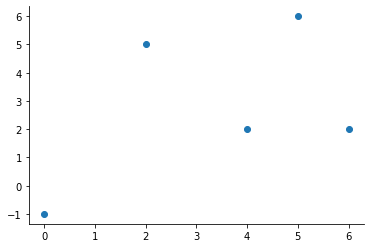

In [15]:
x = [0, 2, 4, 5, 6]
y = [-1, 5, 2, 6, 2]

plt.scatter(x, y)
sns.despine()
plt.show()

## Dla funkcji zadanej określonym wzorem

In [85]:
def plot_fn(fn, min_x, max_x, *, label='', title='Plot', color='b', step=.1):
    xs = np.arange(min_x, max_x, step)
    plt.plot(xs, [fn(x) for x in xs], color, label=label)
    if label: plt.legend(loc='best')
    plt.title(title)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    sns.despine()

###### Testy

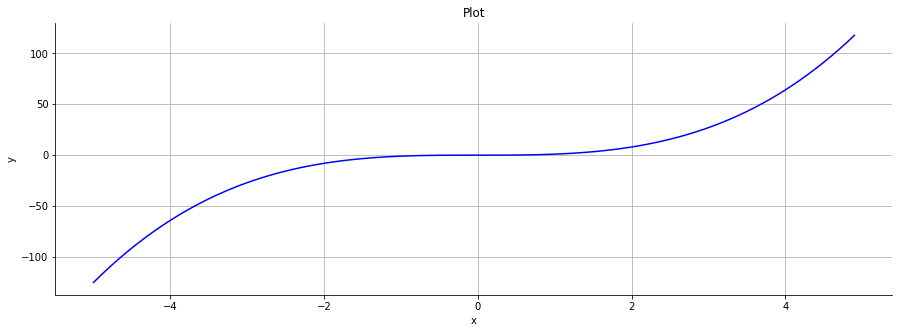

In [96]:
f = lambda x: x ** 3
plt.figure(figsize=(15, 5))
plot_fn(f, -5, 5)
plt.show()

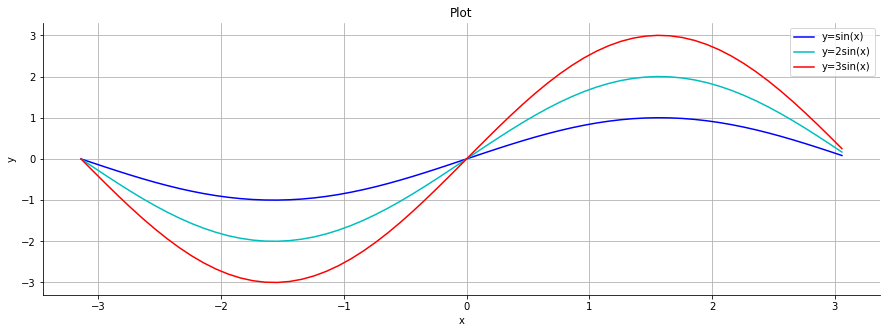

In [95]:
min_x = -np.pi
max_x = np.pi
plt.figure(figsize=(15, 5))
plot_fn(lambda x: np.sin(x), min_x, max_x, color='b', label='y=sin(x)')
plot_fn(lambda x: 2 * np.sin(x), min_x, max_x, color='c', label='y=2sin(x)')
plot_fn(lambda x: 3 * np.sin(x), min_x, max_x, color='r', label='y=3sin(x)')
plt.show()

# Wyznaczanie węzłów zgodnie z zerami wielomianu Czebyszewa

###### Materiały
- https://www.wikiwand.com/en/Chebyshev_nodes

In [144]:
def chebyshev_nodes(n, interval):
    a, b = interval
    
    xs = []
    for k in range(n, 0, -1):
        xs.append(.5 * (a + b) + .5 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi))
    return xs

In [145]:
chebyshev_nodes(10, [-1, 1])

[-0.9876883405951377,
 -0.8910065241883678,
 -0.7071067811865475,
 -0.45399049973954675,
 -0.15643446504023104,
 0.15643446504023092,
 0.4539904997395468,
 0.7071067811865476,
 0.8910065241883679,
 0.9876883405951378]

# Zagadnienie interpolacji

## Metoda Lagrange'a

### Algorytm wyznaczający wielomian interpolujący

#### Własna implementacja

In [48]:
def lagrange_(xs, ys):
    if len(xs) != len(ys):
        raise ValueError('A list of x values has different size than a list of y values')

    ms = []
    
    for xk in xs:
        m = 1
        for xi in xs:
            if xi != xk:
                m *= (xk - xi)
        ms.append(m)
    
    def f(x):
        y = 0
        
        for k, yk in enumerate(ys):
            d = 1
            for i, xi in enumerate(xs):
                if i == k: continue
                d *= (x - xi)
                
            y += d * yk / ms[k]
        
        return y
            
    return f

###### Testy

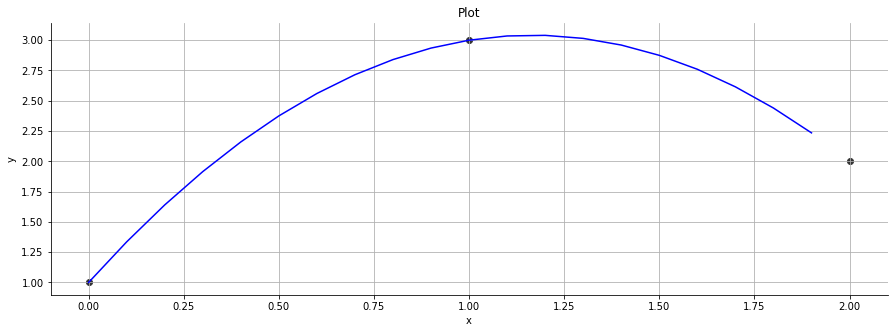

In [97]:
x = [0, 1, 2]
y = [1, 3, 2]

f1 = lagrange_(x, y)
plt.figure(figsize=(15, 5))
plot_fn(f1, min(x), max(x))
plt.scatter(x, y, color='#333')
plt.show()

#### Implementacja z biblioteki scipy

###### Testy

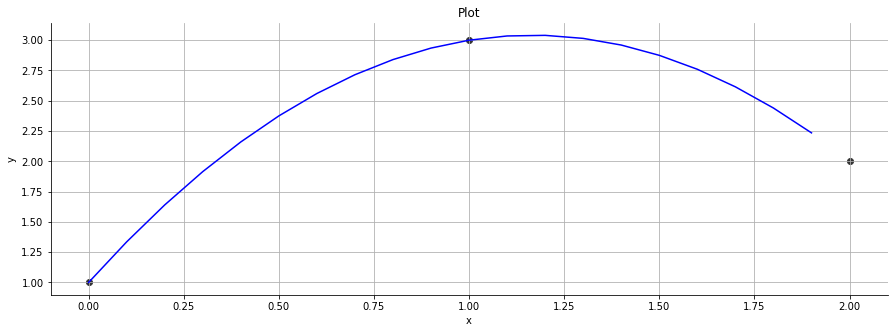

In [101]:
x = [0, 1, 2]
y = [1, 3, 2]

f2 = lagrange(x, y)
plt.figure(figsize=(15, 5))
plot_fn(f2, min(x), max(x))
plt.scatter(x, y, color='#333')
plt.show()

### Przykład dla równomiernie rozdystrybuowanych węzłów

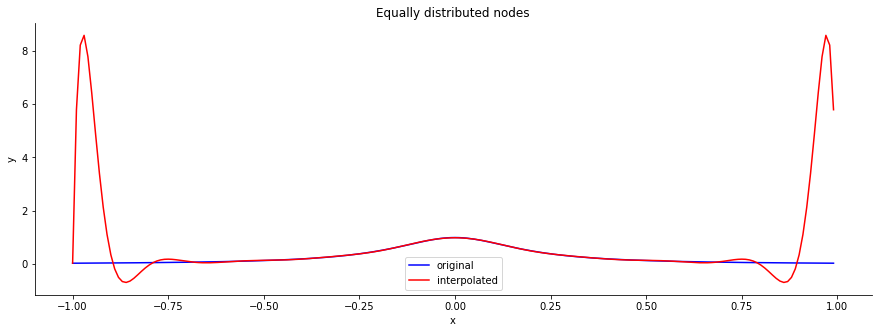

In [160]:
n = 20
f = lambda x: 1 / (1 + 25 * x ** 2)
x = np.linspace(-1, 1, n)  # <- x_0 = -1, h = 2/n
y = [f(xi) for xi in x]

f_inter = lagrange_(x, y)
plt.figure(figsize=(15, 5))
plot_fn(f, min(x), max(x), step=.01, label='original')
plot_fn(f_inter, min(x), max(x), step=.01, title='Equally distributed nodes', color='r', label='interpolated')

### Przykład dla węzłów rozdystrybuowanych zgodnie z zerami wielomianu Czebyszewa

Widzimy znaczącą poprawę dopasowania interpolowanego wielomianu do punktów. Korzystająć z węzłów, wyznaczonych zgodnie z zerami wielomianu Czebyszewa, możemy zauwayżyć, że wraz ze wzrostem liczby węzłów, wzrasta dokładność dopasowania wielomianu interpolowanego (w przypadku dla równomiernego rozdystrybuowania, wzrost liczby węzłów powodował spadek dokładności dopasowania wielomianu interpolowanego)

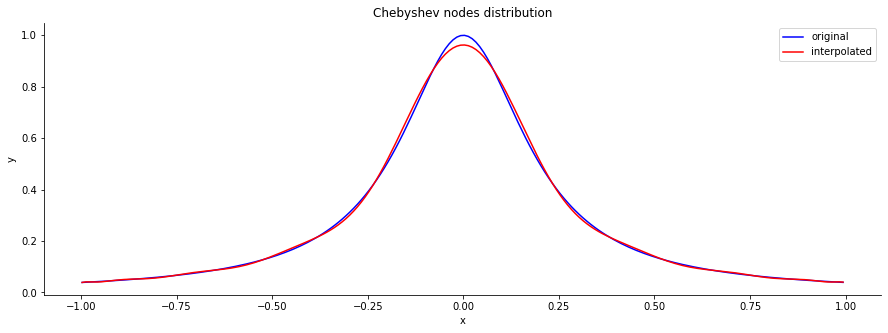

In [163]:
n = 20
f = lambda x: 1 / (1 + 25 * x ** 2)
x = chebyshev_nodes(n, [-1, 1])
y = [f(xi) for xi in x]

f_inter = lagrange_(x, y)
plt.figure(figsize=(15, 5))
plot_fn(f, min(x), max(x), step=.01, label='original')
plot_fn(f_inter, min(x), max(x), step=.01, title='Chebyshev nodes distribution', color='r', label='interpolated')

## Metoda Newtona (ilorazów różnicowych)

### Algorytm wyznaczający wielomian interpolujący dla dowolnego rozkładu węzłów

###### Materiały
- https://www.youtube.com/watch?v=hcsBjizQ9X8 (świetne omówienie)

In [38]:
def newton(xs, ys):
    if len(xs) != len(ys):
        raise ValueError('A list of x values has different size than a list of y values')
        
    n = len(xs)
    bs = list(ys)
    for j in range(1, n):
        for i in range(n - 1, j - 1, -1):
            bs[i] = (bs[i] - bs[i - 1]) / (xs[i] - xs[i - j])
            
    def f(x):
        x_diffs = [1] + [x - xs[i] for i in range(n - 1)]
        
        y = 0
        x_coeff = 1
        for bi, x_diff in zip(bs, x_diffs):
            x_coeff *= x_diff
            y += bi * x_coeff
            
        return y
            
    return f

###### Testy

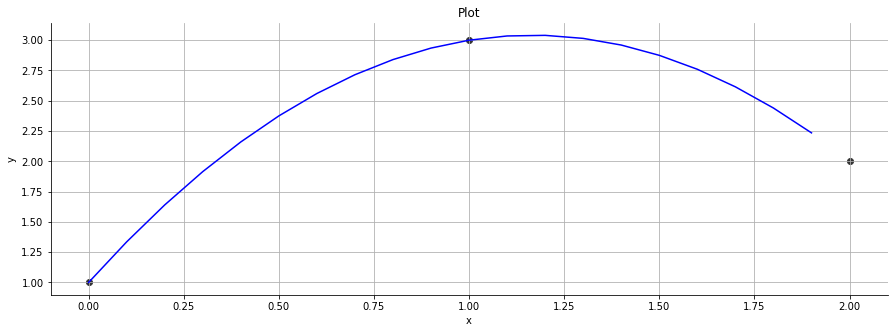

In [102]:
x = [0, 1, 2]
y = [1, 3, 2]

g1 = newton(x, y)
plt.figure(figsize=(15, 5))
plot_fn(g1, min(x), max(x))
plt.scatter(x, y, color='#333')
plt.show()

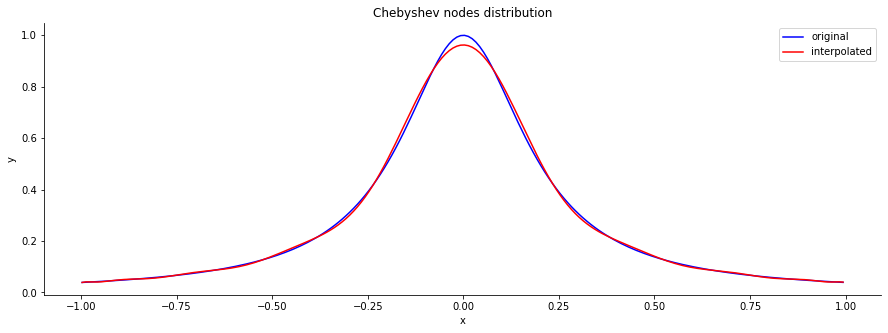

In [185]:
n = 20
f = lambda x: 1 / (1 + 25 * x ** 2)
x = chebyshev_nodes(n, [-1, 1])
y = [f(xi) for xi in x]

f_inter = newton(x, y)
plt.figure(figsize=(15, 5))
plot_fn(f, min(x), max(x), step=.01, label='original')
plot_fn(f_inter, min(x), max(x), step=.01, title='Chebyshev nodes distribution', color='r', label='interpolated')

### Algorytm wyznaczający wielomian interpolujący dla węzłów równomiernie rozdystrybuowanych

###### Materiały
- https://www.emathzone.com/tutorials/basic-statistics/newton-interpolation-formula.html
- https://youtu.be/DRYnS6zB55Y

In [167]:
def memoized(fn):
    cache = {}

    def inner(arg):
        if arg not in cache:
            cache[arg] = fn(arg)
        return cache[arg]
        
    return inner


@memoized
def factorial(n):
    if n in {0, 1}: return 1
    return n * factorial(n - 1)


def _choose_int(n: int, k: int) -> float:
    if k > n: return 0
    if n == k: return 1
    m = factorial(n)
    d = factorial(k) * factorial(n - k)
    return m / d


def _choose_float(n: float, k: int) -> float:
    d = 1
    for i in range(k):
        d *= (n - i)
    return d / factorial(k)

    
def choose(n, k):
    mul = 1
    m = n
    
    if n < 0:
        mul = (-1) ** k
        m = k - n - 1
        
    if n == int(n) and k == int(k):
        return mul * _choose_int(m, k)
    return mul * _choose_float(m, k)


def eqdist_newton(x_0, h, n, ys):
    if n != len(ys):
        raise ValueError('A number of x values is different than a length of a list of y values')
        
    Δ = list(ys)
    for j in range(1, n):
        for i in range(n - 1, j - 1, -1):
            Δ[i] = Δ[i] - Δ[i - 1]
            
    def f(x, *, ε=.00000001):
        s = (x - x_0) / h
        
        y = 0
        for k in range(0, n):
            y += choose(s, k) * Δ[k]
        return y
            
    return f

###### Testy

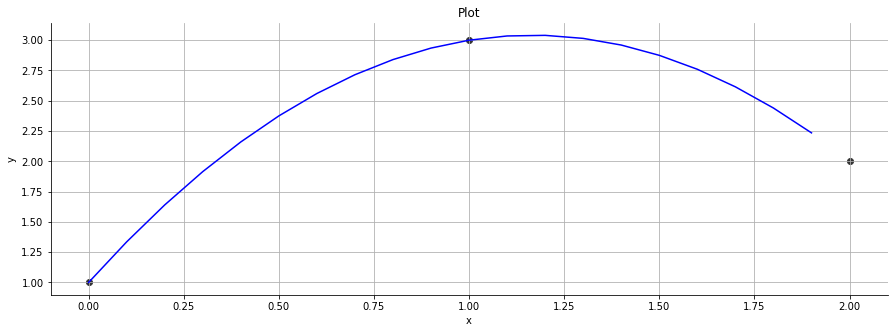

In [172]:
x_0 = 0
h = 1
n = 3
y = [1, 3, 2]

g2 = eqdist_newton(x_0, h, n, y)

plt.figure(figsize=(15, 5))
plot_fn(g2, x_0, x_0 + (n - 1) * h)
plt.scatter([x_0 + i * h for i in range(n)], y, color='#333')
plt.show()

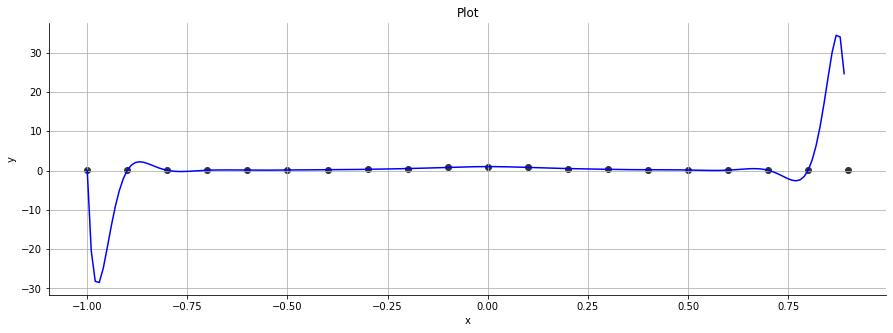

In [184]:
x_0 = -1
h = .1
n = 20
f = lambda x: 1 / (1 + 25 * x ** 2)
y = [f(x_0 + i * h) for i in range(n)]

f_inter = eqdist_newton(x_0, h, n, y)
plt.figure(figsize=(15, 5))
plot_fn(f_inter, x_0, x_0 + (n - 1) * h, step=.01)
plt.scatter([x_0 + i * h for i in range(n)], y, color='#333')
plt.show()